# Práctico 3 - Procesamiento Digital de Imágenes

In [1]:
import imageio.v2 as imageio
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib inline

In [2]:
#%% definición de funciones auxiliares
debug = 0
MAT_RGB2YIQ = np.array([[0.299, 0.587, 0.114],
                        [0.595716,-0.274453,-0.321263],
                        [0.211456,-0.522591, 0.311135]])

def apply_matrix(img, M):
    return np.matmul(img.reshape((-1,3)), M.T).reshape(img.shape)

def rgb2yiq(img):
    return apply_matrix(img, MAT_RGB2YIQ)

def yiq2rgb(img):
    return apply_matrix(img, np.linalg.inv(MAT_RGB2YIQ))

def L2rgb(compL,img_rgb):
        # Img en YIQ con histograma normalizado
        img_yiq = np.concatenate([compL[...,np.newaxis],
                                           rgb2yiq(img_rgb)[:,:,1:3]],axis=2);
        return yiq2rgb(img_yiq)

def plot_hist(imgin,bins,ax):
    # Se procesa un array2D, o img gray o img L
    img = imgin if imgin.ndim==2 else rgb2yiq(imgin)[:,:,0]
    vals_hist, edge_hist = np.histogram(img,bins);
    vals_hist = vals_hist/np.sum(vals_hist);
    ax.bar(edge_hist[:-1],vals_hist,width=1/(2*bins))
    ax.set_xlim([-.2,1.2])
    ax.grid(alpha=0.5)
    return edge_hist[:-1],vals_hist

def norm_hist_minmax(img):
    # Se procesa un array2D, o img gray o img L
    mx = img.max(); mn = img.min();
    img_norm = (img-mn)/(mx-mn) # img con histograma normalizado
    print('Normalizando por min/max del histograma...')
    return img_norm;

def norm_hist_percentil(img,p):
    # Se procesa un array2D, o img gray o img L
    [mn,mx] = np.percentile(img,(p,100-p));
    img_norm = (img-mn)/(mx-mn) # img con histograma normalizado
    print('Normalizando por percentil...')
    return img_norm;

def correccion_gamma(img,gamma):
    # Primer metodo
    t1 = time.perf_counter()
    img_gamma1 = np.power(img,gamma)
    t2 = time.perf_counter()
    print('Tiempo de ejecución primer estrategia: ', 1000*round(t2-t1,5),'[ms]')

    # segundo metodo
    t1 = time.perf_counter()
    img_gamma2 = img**gamma
    t2 = time.perf_counter()
    print('Tiempo de ejecución segunda estrategia: ', 1000*round(t2-t1,5),'[ms]')
    # Se opta por esta segunda alternativa porque ser mas optima computacionalmente(un orden de diferencia)
    return img_gamma2;

def interpolacion(img,val):
    # Se procesa un array2D, o img gray o img L
    import time
    xp = val[0]; yp = val[1]
    
    # Primer metodo
    t1 = time.perf_counter()
    img_interp = np.interp(img,xp,yp)
    t2 = time.perf_counter()
    print('Tiempo de ejecución primer estrategia: ', 1000*round(t2-t1,5),'[ms]')
    return img_interp;
 
def processing_hist(*args):
    # argumentos de entrada: [0]imgin, [1][metodo[minmax,percentil],
    # [2] value
    if len(args) <2: print('Cantidad insuficente de argumentos')
    if len(args)==2: imgin=args[0]; m=args[1];
    if len(args)==3: imgin=args[0]; m=args[1]; val=args[2] 
    if len(args)>3: print('Error, solamente se pueden ingresar hasta 2 argumentos...')

    if imgin.ndim==2:
        img = imgin;
        print('Se esta procesando una img gray.');
    if imgin.ndim==3:
        # Por accidente, podriamos decir que...
        img = rgb2yiq(imgin)[:,:,2]; # img Zombi
        img = rgb2yiq(imgin)[:,:,1]; # img Fluor
        img = rgb2yiq(imgin)[:,:,0]; # siempre se procesa un array2D
        print('Se esta procesando una img rgb.');
        print('Se percibe el incremento de luminosidad y la mejora en los detalles.')
        # Se observan mas detalles en la img, aunque alguna componente quedó clampleada :(

    # Normalización por max y min del histograma
    if m == 'minmax':     img_norm = norm_hist_minmax(img);
    # Normalización por percentiles
    if m == 'percentil':  img_norm = norm_hist_percentil(img,val);
    # Gamma
    if m == 'gamma':  img_norm = correccion_gamma(img,val);
    # Interpolación
    if m == 'interpolacion':  img_norm = interpolacion(img,val);
    
    # Para el caso img_3D (probablmente rgb)
    if imgin.ndim==3: # img RGB
        # Img en YIQ con histograma normalizado
        img_norm = L2rgb(img_norm,imgin);
        if debug:
            print('Img final antes de chequear valores en RGB max y min: ',
              round(img_norm.max(),2),round(img_norm.min(),2));
    
            # Esta estrategia resulto 4 veces mas lenta        
            # for indx,x in np.ndenumerate(img_norm):
            #   if img_norm[indx]>=1: img_norm[indx] = 1
            #   if img_norm[indx]<=0: img_norm[indx] = 0
        # Mejor... estrategia por mascaras            
        img_norm[img_norm>=1] = 1
        img_norm[img_norm<=0] = 0
        if debug:
            print('Img final despues de chequear y campleat en RGB max y min: ',
              round(img_norm.max(),2),round(img_norm.min(),2));  

    return img_norm;

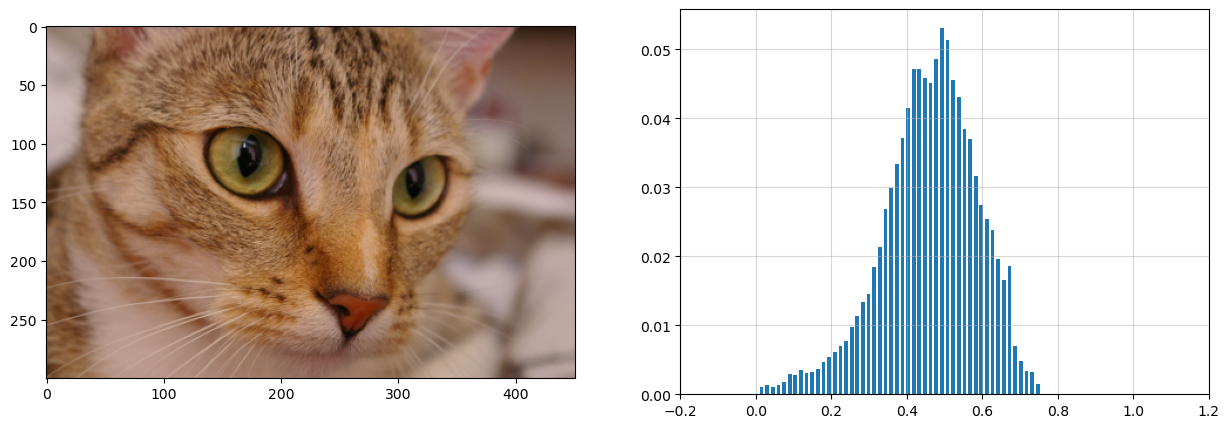

In [3]:
#os.system('cls') 
img_rgb     = imageio.imread('imageio:chelsea.png')/255
img_rgb2yiq = rgb2yiq(img_rgb)
img_gray    = img_rgb2yiq[:,:,0]

_, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].imshow(img_rgb, 'gray', vmin=0, vmax=1)
plot_hist(img_rgb, 50, axes[1]);

# 1.1 Normalizar histograma al rango [0,1]

Definir una función que normalice el histograma de valores de la imagen al rango [0,1]. Si la imagen es RGB, debe normalizar el histograma de luminancias.

Se esta procesando una img rgb.
Se percibe el incremento de luminosidad y la mejora en los detalles.
Normalizando por min/max del histograma...


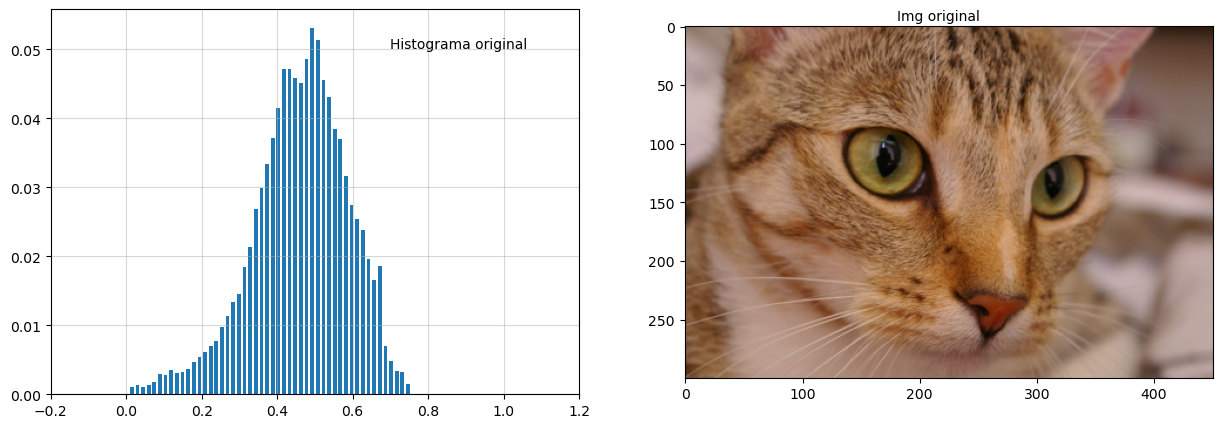

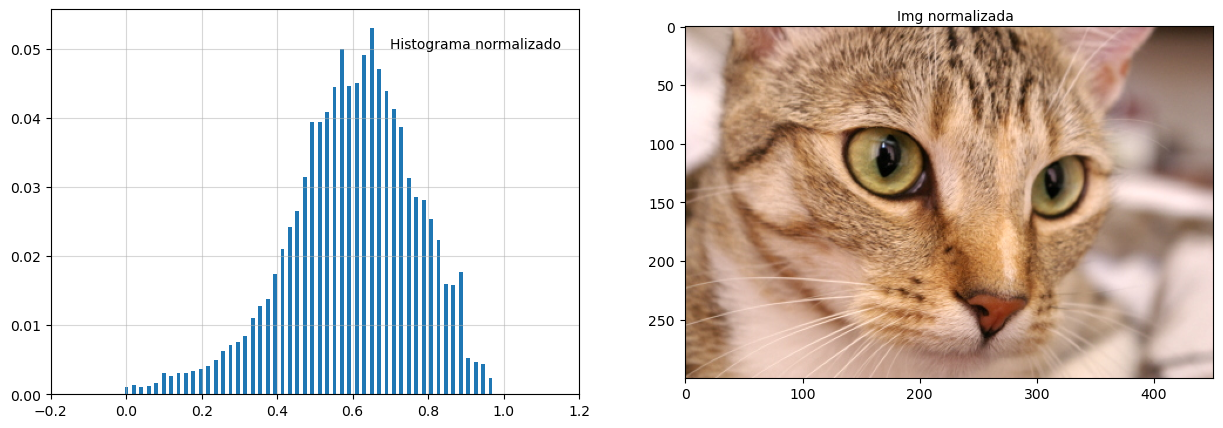

In [4]:
# %% Primer ejercicio: Normalización del histograma
imgin = img_rgb;
bins = 50;

# Img original
_, ax1 = plt.subplots(1, 2, figsize=(15,5));
plot_hist(imgin,bins,ax1[0]); ax1[0].text(.7,.9*ax1[0].get_ylim()[1], 'Histograma original');
ax1[1].imshow(imgin,'gray'); ax1[1].text(.4*ax1[1].get_xlim()[1],-5, 'Img original');

# Processing
imgout = processing_hist(imgin,'minmax');

# Img final
_, ax2 = plt.subplots(1, 2, figsize=(15,5));
plot_hist(imgout,bins,ax2[0]);ax2[0].text(.7,.9*ax2[0].get_ylim()[1], 'Histograma normalizado');
ax2[1].imshow(imgout,'gray'); ax2[1].text(.4*ax2[1].get_xlim()[1],-5, 'Img normalizada');
 


## mini - conclusiones
####  .- Se cumplio el objetivo propuesto.
####  .- Para el caso imgray no se *observa* mejoría.
#### .- Con la img rgb al procesar la componente Y,
        # Se percibe el incremento de luminosidad y la mejora en los detalles.    
        # Al trabajar en el espacio YIQ, revisar que los valores de Y esten en el
        #vintervalo [0,1]... sucedde que al volver al espacio RGB se camplea alguna de las componentes :(. 
        # update 18.05.23: el problema esta con la funcion yiq2rgb ()sifuiendo el workfloe
        # Slides2, pag.27 las compoentes R, G y B estan fuera de rango.

        # Despues de procesar en el espacio YIQ, a pesar de verificar los valores en Slides2, pag.27
        # sucedde que al volver al espacio RGB se igualmente alguna componente :(... con imshow por ej. 
        # Se agregaron entonces una lineas para chequear y camplear las compoenentes R, G y B.
        


## 1.2 Normalizar histograma usando percentiles

Definir una función que normalice el histograma de valores de la imagen de modo que el pixel del percentil P valga 0 y el pixel del percentil 100-P valga 1. Los valores entre los percentiles 0 y P valdrán 0 y los valores entre los percentiles 100-P y 100 valdrán 1. Si la imagen es RGB, normalizar el histograma de luminancias.

NOTA: para calcular percentiles usar np.percentile()

Se esta procesando una img rgb.
Se percibe el incremento de luminosidad y la mejora en los detalles.
Normalizando por percentil...


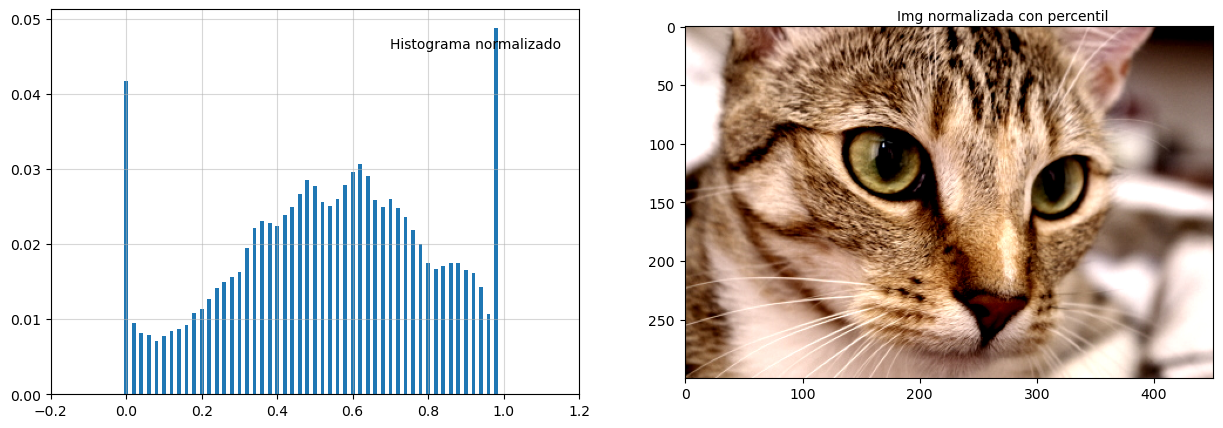

In [5]:
# %% Primer ejercicio: Normalización del histograma con percentiles
# Mismo procedimiento que el inciso anterior, solo que en lugar de corregir por 
# valor max y min del histograma, se corrige con los percentiles. 
# Es de esperarse que esto ocasione que el hist final quede fuera del rango [0,1].
imgin = img_rgb;
bins = 50;
p = 5;

# Processing
imgout = processing_hist(imgin,'percentil',p);

# Img final
_, ax2 = plt.subplots(1, 2, figsize=(15,5));
plot_hist(imgout,bins,ax2[0]);ax2[0].text(.7,.9*ax2[0].get_ylim()[1], 'Histograma normalizado');
ax2[1].imshow(imgout,'gray'); ax2[1].text(.4*ax2[1].get_xlim()[1],-5, 'Img normalizada con percentil');

## 2. Corrección gamma

1. Definir una función que aplique la corrección gamma a una imagen. Si la imagen es RGB, debe aplicar la corrección sobre la luminosidad de la imagen.
2. Normalizar la imagen al rango [0,1] (con min y max o con percentiles) y luego aplicar corrección gamma.


Como sugerencia, pasarle como parámetro un valor $\alpha$ de manera que $\gamma$ se calcule como:

$\gamma = 2^{-\alpha}$

De esta manera, cuando $\alpha=1 \rightarrow \gamma=1/2$, y cuando $\alpha=-1 \rightarrow \gamma=2$. Entonces, para $\alpha>0$ la luminosidad aumenta y para $\alpha<0$ disminuye.

Se esta procesando una img rgb.
Se percibe el incremento de luminosidad y la mejora en los detalles.
Normalizando por min/max del histograma...
Se esta procesando una img rgb.
Se percibe el incremento de luminosidad y la mejora en los detalles.
Tiempo de ejecución primer estrategia:  6.39 [ms]
Tiempo de ejecución segunda estrategia:  0.48000000000000004 [ms]


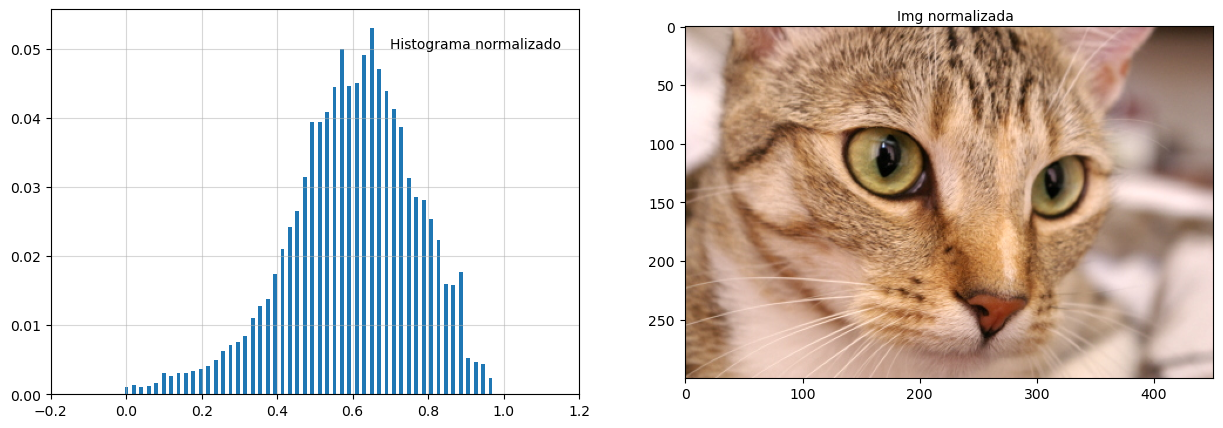

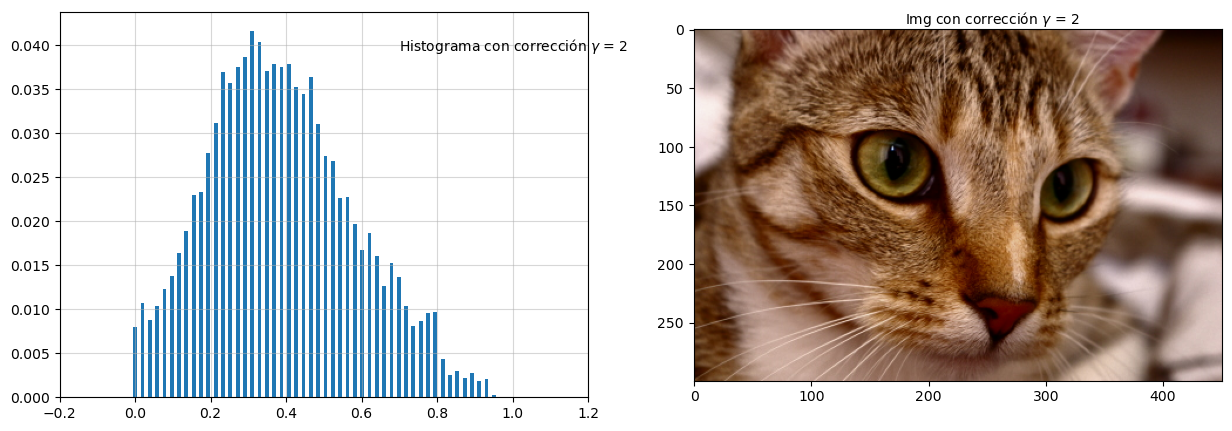

In [6]:
imgin = img_rgb;
bins = 50;
gamma = 2;

# Img normalizda
imgout = processing_hist(imgin,'minmax');
_, ax1 = plt.subplots(1, 2, figsize=(15,5));
plot_hist(imgout,bins,ax1[0]); ax1[0].text(.7,.9*ax1[0].get_ylim()[1], 'Histograma normalizado');
ax1[1].imshow(imgout,'gray'); ax1[1].text(.4*ax1[1].get_xlim()[1],-5, 'Img normalizada');

# Processing
imgout = processing_hist(imgout,'gamma',gamma);

# Img final
_, ax2 = plt.subplots(1, 2, figsize=(15,5));
plot_hist(imgout,bins,ax2[0]);ax2[0].text(.7,.9*ax2[0].get_ylim()[1],
            'Histograma con corrección ' + r'$\gamma$ = ' + str(gamma));
ax2[1].imshow(imgout,'gray'); ax2[1].text(.4*ax2[1].get_xlim()[1],-5,
             'Img con corrección ' + r'$\gamma$ = ' + str(gamma));

## mini - conclusiones
#### Para modificar cada uno de los pixeles, resulta  eficiente computacionalmente  usar (**) en lugar de np. power() en alrededor de un orden de magnidud.

# 3. Modificación del histograma por una función definida a tramos

1. Definir una función que tome una imagen y dos arreglos $x$ e $y$ que definan una función no-lineal en el rango $0\leq x,y\leq 1$ y aplique la función a la intensidad de los pixeles de la imagen. Si la imagen es RGB debe aplicar la función a la luminosidad de la imagen.
2. Normalizar la imagen al rango [0,1] y luego aplicar corrección gamma.

Ayuda: La función np.interp() puede facilitarle la tarea

Se esta procesando una img rgb.
Se percibe el incremento de luminosidad y la mejora en los detalles.
Normalizando por min/max del histograma...
Se esta procesando una img rgb.
Se percibe el incremento de luminosidad y la mejora en los detalles.
Tiempo de ejecución primer estrategia:  2.97 [ms]


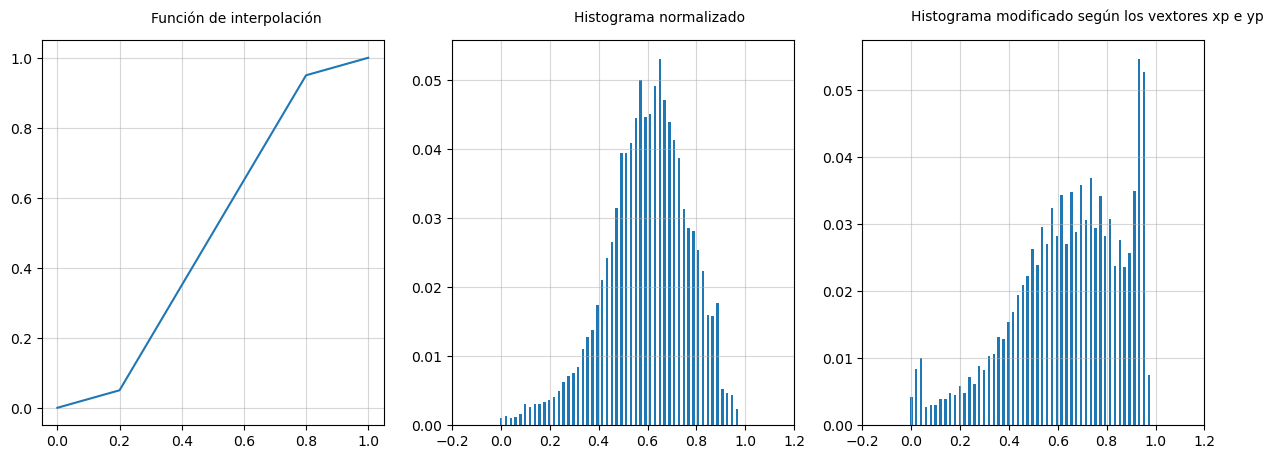

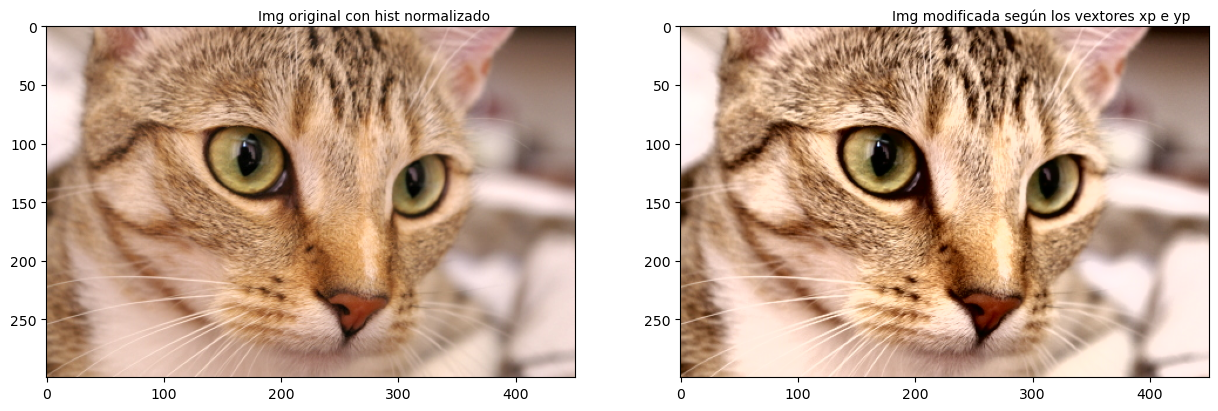

In [7]:
import time
imgin = img_rgb;
bins = 50;

xp = np.array([0, 0.2,  0.8,  1]);
yp = np.array([0, 0.05, 0.95, 1]);

# Img normalizda
img_norm = processing_hist(imgin,'minmax');

# Img interpolada
img_interp = processing_hist(img_norm,'interpolacion',(xp,yp));

# Graficas
_, ax1 = plt.subplots(1, 3, figsize=(15,5));
ax1[0].plot(xp,yp);    ax1[0].grid(alpha=0.5);
ax1[0].text(.3,1.1*ax1[1].get_ylim()[1], 'Función de interpolación');
plot_hist(img_norm,bins,ax1[1]);
ax1[1].text(.3,1.05*ax1[1].get_ylim()[1], 'Histograma normalizado');
plot_hist(img_interp,bins,ax1[2]);ax1[2].text(0,1.05*ax1[2].get_ylim()[1],
            'Histograma modificado según los vextores xp e yp');

_, ax2 = plt.subplots(1, 2, figsize=(15,5));
ax2[0].imshow(img_norm,'gray'); ax2[0].text(.4*ax2[0].get_xlim()[1],-5, 'Img original con hist normalizado');

ax2[1].imshow(img_interp,'gray'); ax2[1].text(.4*ax2[1].get_xlim()[1],-5,
             'Img modificada según los vextores xp e yp');

## mini - conclusiones
#### El gato se convierte en tigre :).


# 4. Uniformalización del histograma

1. Definir una función que tome una imagen y haga que su histograma de intensidades tenga una distribución uniforme. 
2. Normalizar el histograma al rango [0,1] y uniformalizar su distribución

Se esta procesando una img rgb.
Se percibe el incremento de luminosidad y la mejora en los detalles.
Normalizando por min/max del histograma...
Se esta procesando una img rgb.
Se percibe el incremento de luminosidad y la mejora en los detalles.
Tiempo de ejecución primer estrategia:  3.0599999999999996 [ms]


Text(180.20000000000002, -5, 'Img modificada según los vextores xp e yp')

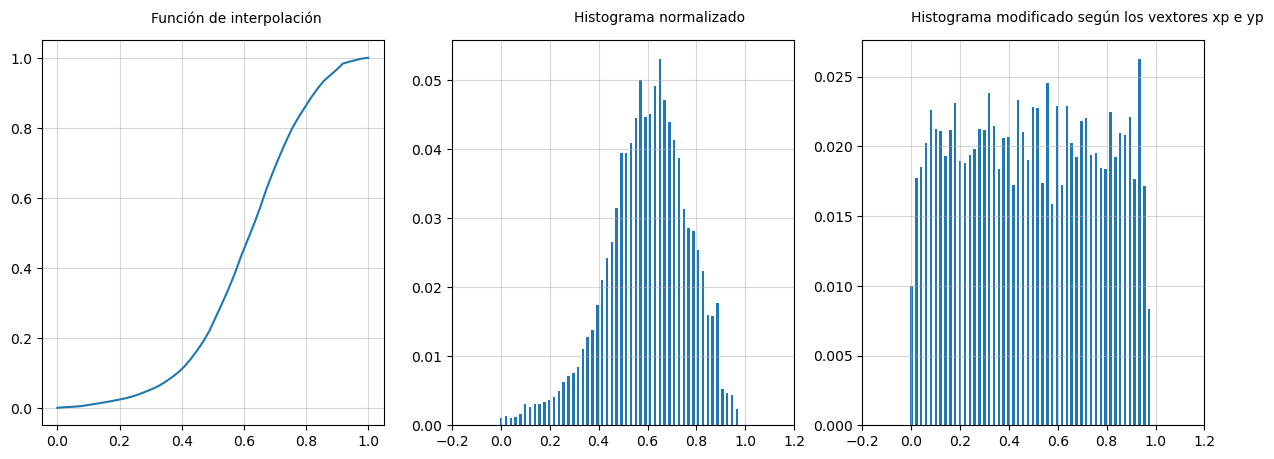

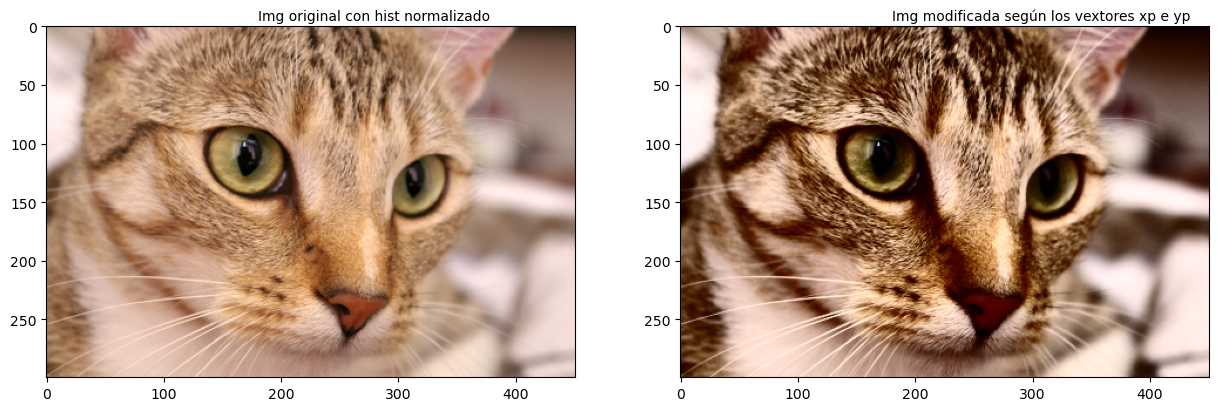

In [8]:
imgin = img_rgb;
bins = 50;

# Img normalizda
img_norm = processing_hist(imgin,'minmax');

# histograma de area unitaria
x_hist,vals_hist  = plot_hist(img_norm,bins,ax1[1]);
yp = np.cumsum(vals_hist); # Fx para uniformalización
#xp = x_hist;
xp = np.linspace(0,1,len(vals_hist));

# Img interpolada con la Fx
img_interp = processing_hist(img_norm,'interpolacion',(xp,yp));

# Graficas
_, ax1 = plt.subplots(1, 3, figsize=(15,5))
ax1[0].plot(xp,yp);    ax1[0].grid(alpha=0.5);
ax1[0].text(.3,1.1*ax1[1].get_ylim()[1], 'Función de interpolación')
plot_hist(img_norm,bins,ax1[1]);
ax1[1].text(.3,1.05*ax1[1].get_ylim()[1], 'Histograma normalizado')
plot_hist(img_interp,bins,ax1[2]);ax1[2].text(0,1.05*ax1[2].get_ylim()[1],
            'Histograma modificado según los vextores xp e yp')

_, ax2 = plt.subplots(1, 2, figsize=(15,5))
ax2[0].imshow(img_norm,'gray'); ax2[0].text(.4*ax2[0].get_xlim()[1],-5, 'Img original con hist normalizado')

ax2[1].imshow(img_interp,'gray'); ax2[1].text(.4*ax2[1].get_xlim()[1],-5,
             'Img modificada según los vextores xp e yp')


## mini - conclusiones
#.-Se cumplio el objetivo propuesto.

#.-Se utiliza como función de interpolación (para conseguir que el histograma tenga una distribución uniforme) a la distribución acumulada $F_x(x)$ de la img después de normalizar su histograma (en escala de grises o componente Y). 


# 5. Normalización del histograma

1. Definir una función que tome una imagen y haga que su histograma de intensidades tenga una distribución normal. 
2. Normalizar el histograma al rango [0,1] y normalizar su distribución.

## Incompleto
#.-La idea era seguir el siguiente procedimiento de dos transformaciones:

#1.- Hacer que el histograma tenga una distribución uniforme como en la actividad anterior.

#2.- Transformar los datos de intesidad con la $F_x(x)$ de una VA gausiana normalizada.